In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
from scipy.fftpack import dctn, idctn
from tqdm import tqdm
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

sys.path.append(str(Path("..").resolve()))
from src import *

/leonardo_scratch/fast/IscrC_MACRO/CalciumImagingDenoising/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Video Fusion With Discrete Cosine Transform (DCT) [Synthetic]
Can we augment a denoiser output using a sliding window on the raw footage and DCT video fusion?

This can be used to **reduce the number of training steps for deep-learning models**, which are known to be expensive to train. This is the case with DeepCAD-RT, which uses a 3D UNet.

In [3]:
patch_xy = 490
frames_per_patch = 150
window = 150

In [8]:
x_path = DATASETS["synthetic"].dir / "noise_1Q_-5.52dBSNR_490x490x6000.tif"
y_path = DATASETS["synthetic"].dir / "deepcad_E_10.tif"
gt_path = DATASETS["synthetic"].dir / "clean_30Hz_490x490x6000.tif"
x, y, gt = (Recording(_, max_frames=frames_per_patch*2) for _ in [x_path, y_path, gt_path])
RES_DIR = Path("results/synthetic/")
RES_DIR.mkdir(exist_ok=True)

In [23]:
patch = x.np[:, :patch_xy, :patch_xy]
patch_deepcad = y.np[:, :patch_xy, :patch_xy]
patch_mean = x.avg(window).np[:, :patch_xy, :patch_xy]

Averaging frames...: 100%|██████████| 300/300 [00:05<00:00, 54.24it/s]


In [24]:
def merge_dct(dct_hf_xy, dct_hf_z, s0, δ_s, t0, δ_t):
    T, H, W = dct_hf_xy.shape
    t = np.arange(T)[:, None, None]
    y = np.arange(H)[None, :, None]
    x = np.arange(W)[None, None, :]

    # normalized ramps in [0,1]
    r = np.sqrt(y**2 + x**2)
    w_s = np.clip((r - (s0 - δ_s)) / (2 * δ_s), 0, 1)  # grows from 0→1 around s0
    w_t = np.clip((t - (t0 - δ_t)) / (2 * δ_t), 0, 1)  # grows from 0→1 around t0

    # combined weight for dct1: high spatial but suppressed by temporal
    W1 = w_s * (1 - w_t)
    merged = W1 * dct_hf_xy + (1 - W1) * dct_hf_z

    return W1, merged, idctn(merged, norm="ortho")

In [25]:
patch_deepcad_dct = dctn(patch_deepcad, type=2, norm="ortho")
patch_mean_dct = dctn(patch_mean, type=2, norm="ortho")

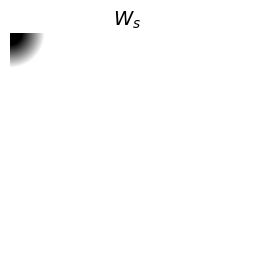

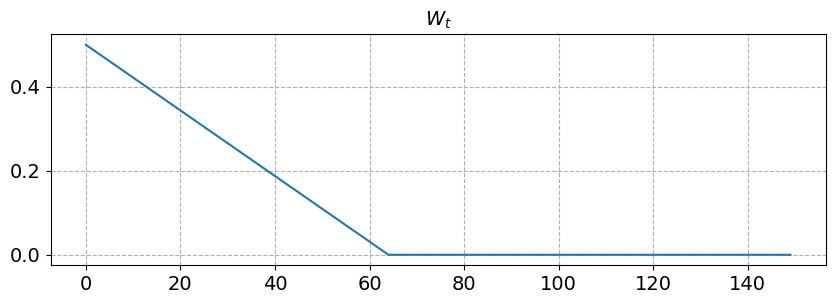

In [5]:
s0 = 8 
δ_s = 24 
t0 = 0
δ_t = 64

W_s = np.clip(
    (np.sqrt(np.arange(patch_xy)[None, :] ** 2 + np.arange(patch_xy)[:, None] ** 2) - (s0 - δ_s)) / (2 * δ_s), 0, 1
)
W_t = 1 - np.clip((np.arange(frames_per_patch) - (t0 - δ_t)) / (2 * δ_t), 0, 1)
imshow({"$W_s$": W_s}, size=3)
pd.Series(W_t).plot(figsize=(10, 3), title="$W_t$");

DeepCAD frames


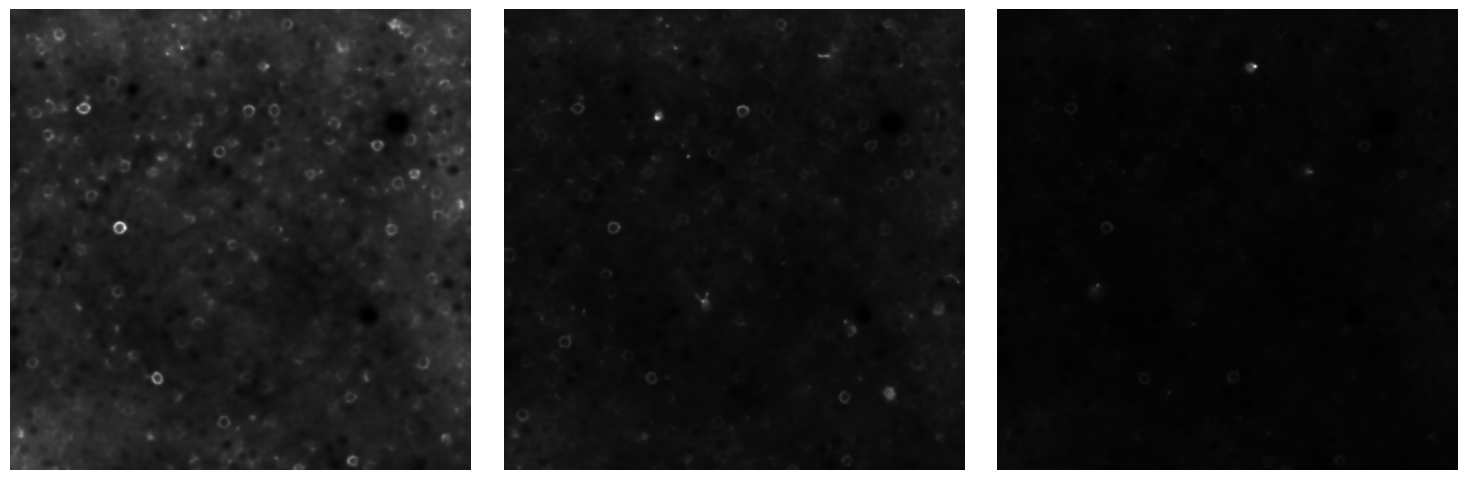

Fused frames


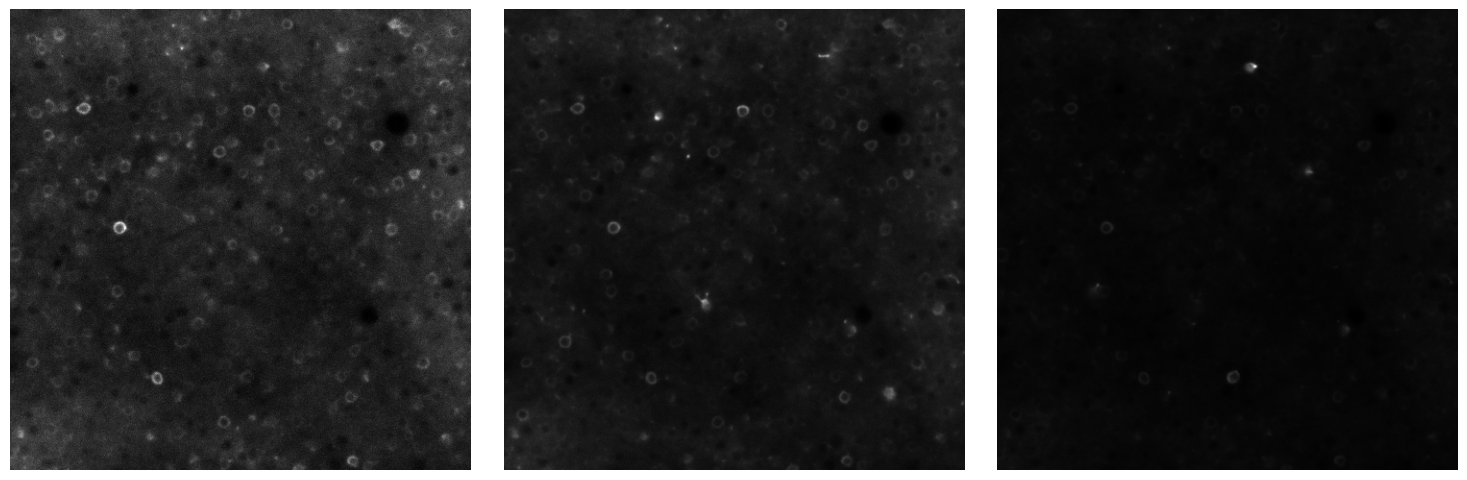

Averaged frames


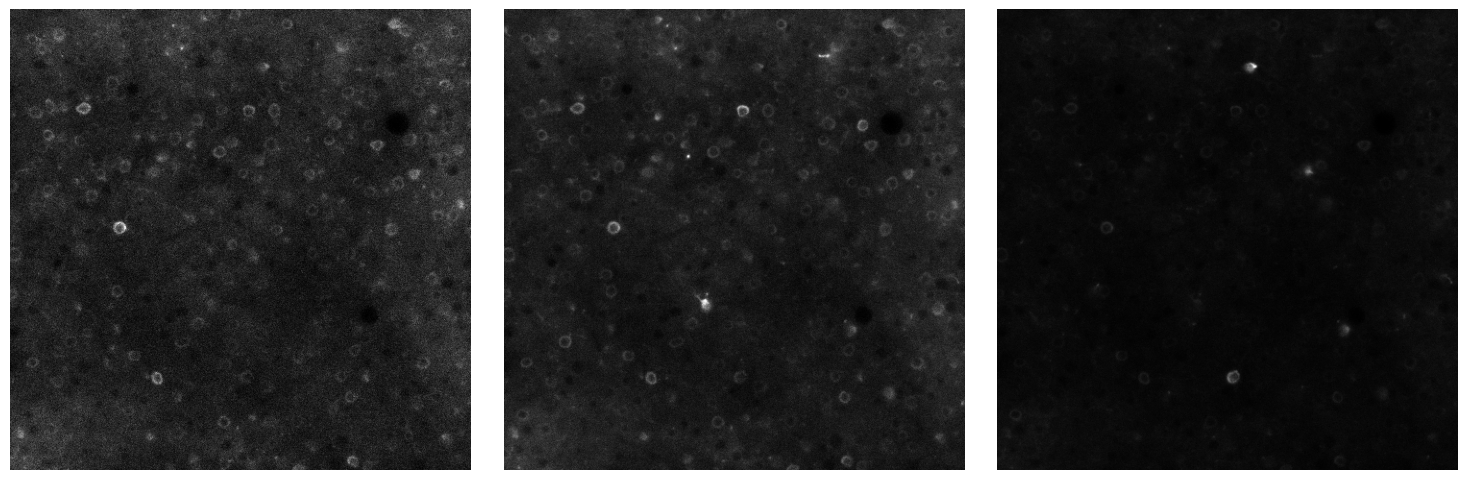

In [28]:
max_frames=3
W, fused_dct, fused = merge_dct(patch_mean_dct, patch_deepcad_dct, s0, δ_s, t0, δ_t)
# cprint("green:Weight mask in DCT space")
# imshow([_ for _ in W[::64]], cmap="grey", size=2, cols=8, vrange=(0, 1))
# imshow([_ for _ in fused_dct[::16]], cmap="grey", size=5, cols=max_frames)
cprint("blue:DeepCAD frames")
imshow([_ for _ in patch_deepcad[::128]], cmap="grey", size=5, cols=max_frames)
cprint("yellow:Fused frames")
imshow([_ for _ in fused[::128]], cmap="grey", size=5, cols=max_frames)
cprint("red:Averaged frames")
imshow([_ for _ in patch_mean[::128]], cmap="grey", size=5, cols=max_frames)

In [33]:
Recording(fused).render(RES_DIR/f"dct_fused_w{window}_{s0}_{δ_s}_{t0}_{δ_t}.mp4")

x265 [info]: HEVC encoder version 3.5+1-f0c1022b6
x265 [info]: build info [Linux][GCC 8.3.0][64 bit] 8bit+10bit+12bit
x265 [info]: using cpu capabilities: MMX2 SSE2Fast LZCNT SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x265 [info]: Main profile, Level-3 (Main tier)
x265 [info]: Thread pool created using 12 threads
x265 [info]: Slices                              : 1
x265 [info]: frame threads / pool features       : 3 / wpp(8 rows)
x265 [warning]: Source height < 720p; disabling lookahead-slices
x265 [info]: Coding QT: max CU size, min CU size : 64 / 8
x265 [info]: Residual QT: max TU size, max depth : 32 / 1 inter / 1 intra
x265 [info]: ME / range / subpel / merge         : hex / 57 / 2 / 3
x265 [info]: Keyframe min / max / scenecut / bias  : 25 / 250 / 40 / 5.00 
x265 [info]: Lookahead / bframes / badapt        : 20 / 4 / 2
x265 [info]: b-pyramid / weightp / weightb       : 1 / 1 / 0
x265 [info]: References / ref-limit  cu / depth  : 3 / off / on
x265 [info]: AQ: mode / str / qg-size / cu-tree  

## PSNR and SSIM evaluation

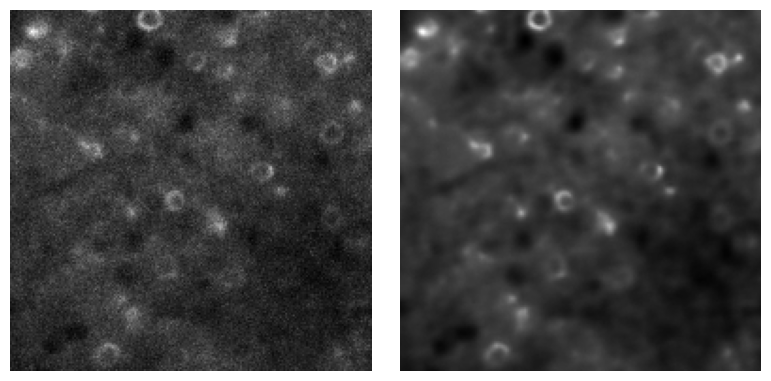

In [32]:
imshow([fused[0], patch_deepcad[0]], zoom=2.5)